<a href="https://colab.research.google.com/github/emm-gl/WA2501_Machine_Learning_AI/blob/main/Examen_Working_Analyst_M%C3%B3dulo_II_regresi%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working Analyst Módulo II: Regresión
**Nombre:** Emmanuel González Calitl

## Cargar bibiliotecas y funciones

In [486]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler         # solamente para la comparación da la improtancia entre variables explicativas
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns


In [487]:
def correlacion(dataframe, grafica=True, matrix=True, tamaño =(6, 4)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [488]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'null','nunique','unique' ]
  return(descripcion)

In [489]:
def convert_binary_to_int(df):
  for column in df.columns:
    if df[column].nunique() == 2:
      df[column] = df[column].astype(int)
  return df

# Lectura datos y selección de características

__Cargar etiquetas__

In [490]:
# Variables respuesta
Ys = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/y.csv',
                     index_col=[0], sep=',',)
print(Ys.shape)
Ys.head(2)

(37368, 1)


,price
id_annonce,
35996577,355000.0
35811033,190000.0


__Cargar características__

In [491]:
# Conjunto de caracteristicas (X)
X = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/X.csv',
                sep=',', index_col=[0])
print(X.shape)
X.head(2)

(37368, 26)


,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,energy_performance_category,...,nb_parking_places,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors
id_annonce,,,,,,,,,,,,,,,,,,,,,
35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,NaN,...,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,D,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [492]:
df_raw = pd.merge(X, Ys, on='id_annonce', how='inner')
df_raw.head(10)

,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,energy_performance_category,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price
id_annonce,,,,,,,,,,,,,,,,,,,,,
35996577,appartement,43.643880,7.117183,villeneuve-loubet,6270,63.0,NaN,NaN,NaN,NaN,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,355000.0
35811033,appartement,45.695757,4.895610,venissieux,69200,90.0,3.0,NaN,223.0,D,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0
35731841,maison,47.966791,-1.220451,moutiers,35130,61.0,NaN,370.0,NaN,NaN,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39000.0
35886765,maison,47.289292,-1.878805,cordemais,44360,142.0,NaN,764.0,217.0,D,...,1.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,299000.0
35781137,appartement,45.718992,4.844234,lyon-7eme,69007,88.0,3.0,NaN,NaN,NaN,...,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,478000.0
36048491,appartement,48.698844,2.309213,chilly-mazarin,91380,92.0,NaN,NaN,161.0,D,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249000.0
36049101,appartement,48.884067,2.270220,neuilly-sur-seine,92200,1758.0,5.0,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2050000.0
35886249,maison,48.698043,-3.093175,quemper-guezennec,22260,120.0,NaN,25700.0,193.0,D,...,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,241000.0
36058309,maison,42.707206,3.024995,canet-en-roussillon,66140,110.0,NaN,392.0,89.0,B,...,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334400.0


In [493]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37368 entries, 35996577 to 35748883
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   property_type                37368 non-null  object 
 1   approximate_latitude         37368 non-null  float64
 2   approximate_longitude        37368 non-null  float64
 3   city                         37368 non-null  object 
 4   postal_code                  37368 non-null  int64  
 5   size                         36856 non-null  float64
 6   floor                        9743 non-null   float64
 7   land_size                    15581 non-null  float64
 8   energy_performance_value     19068 non-null  float64
 9   energy_performance_category  19068 non-null  object 
 10  ghg_value                    18530 non-null  float64
 11  ghg_category                 18530 non-null  object 
 12  exposition                   9094 non-null   object 
 13  nb_rooms   

**Observaciones:**
- 27 Columnas
- 37 368 registros
- Valores nulos en ciertas columnas (Imputar datos o borrarlos)

<h2> Identificación del tipo de variable de cada columna

Comparamos el tipo de cada columna con la documentación de los parámetros de entrada

In [494]:
describe_datos(df_raw)

,dtypes,null,nunique,unique
property_type,object,0,22,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37368,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37368,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8643,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,int64,0,4726,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,512,4478,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,27625,24,"[nan, 3.0, 5.0, 1.0, 2.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,21787,3721,"[nan, 370.0, 764.0, 25700.0, 392.0, 2600.0, 78..."
energy_performance_value,float64,18300,642,"[nan, 223.0, 217.0, 161.0, 193.0, 89.0, 220.0,..."
energy_performance_category,object,18300,7,"[nan, D, B, C, A, E, F, G]"


Convertir las columnas que tiene valores boleanos a tipo entero:

In [495]:
# Function to get unique counts or total length for numerical columns
def unique_or_len(series):
    return series.nunique()

# Create the summary DataFrame
df_summary = pd.DataFrame({
    'Column': df_raw.columns,
    'Total_Unique_Values': [unique_or_len(df_raw[col]) for col in df_raw.columns],
    'Type': df_raw.dtypes
})

df_summary.reset_index(drop=True, inplace=True)

In [496]:
#Encontrar columnas con valores booleanos:
df_summary[df_summary['Total_Unique_Values'] == 2].sort_values(by='Total_Unique_Values', ascending=False)

,Column,Total_Unique_Values,Type
16,nb_parking_places,2,float64
17,nb_boxes,2,float64
19,has_a_balcony,2,float64
20,nb_terraces,2,float64
21,has_a_cellar,2,float64
22,has_a_garage,2,float64
23,has_air_conditioning,2,float64
24,last_floor,2,float64
25,upper_floors,2,float64


In [497]:
df_raw = convert_binary_to_int(df_raw)

In [498]:
describe_datos(df_raw)

,dtypes,null,nunique,unique
property_type,object,0,22,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37368,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37368,"[7.117182951005137, 4.89560993095212, -1.22045..."
city,object,0,8643,"[villeneuve-loubet, venissieux, moutiers, cord..."
postal_code,int64,0,4726,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,512,4478,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
floor,float64,27625,24,"[nan, 3.0, 5.0, 1.0, 2.0, 55.0, 6.0, 4.0, 8.0,..."
land_size,float64,21787,3721,"[nan, 370.0, 764.0, 25700.0, 392.0, 2600.0, 78..."
energy_performance_value,float64,18300,642,"[nan, 223.0, 217.0, 161.0, 193.0, 89.0, 220.0,..."
energy_performance_category,object,18300,7,"[nan, D, B, C, A, E, F, G]"


<h2> Análisis de nulos:

In [499]:
df_raw.isna().sum().sort_values(ascending=False)

,0
exposition,28274
floor,27625
land_size,21787
ghg_category,18838
ghg_value,18838
energy_performance_category,18300
energy_performance_value,18300
nb_bathrooms,13273
nb_bedrooms,2733
nb_rooms,1566


11 Columnas de 24, tiene valores Nans

In [500]:
# Calcular total de filas
total_rows = len(df_raw)

# Calcular nulos y porcentaje
missing_values = df_raw.isna().sum()
missing_percentage = (missing_values / total_rows) * 100

# Crear DataFrame con solo las columnas que tienen NaNs
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
}).loc[lambda x: x['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

# Mostrar el resultado
missing_summary


,Missing Values,Percentage (%)
exposition,28274,75.663669
floor,27625,73.926889
land_size,21787,58.303896
ghg_value,18838,50.412117
ghg_category,18838,50.412117
energy_performance_value,18300,48.972383
energy_performance_category,18300,48.972383
nb_bathrooms,13273,35.519696
nb_bedrooms,2733,7.313744
nb_rooms,1566,4.190751


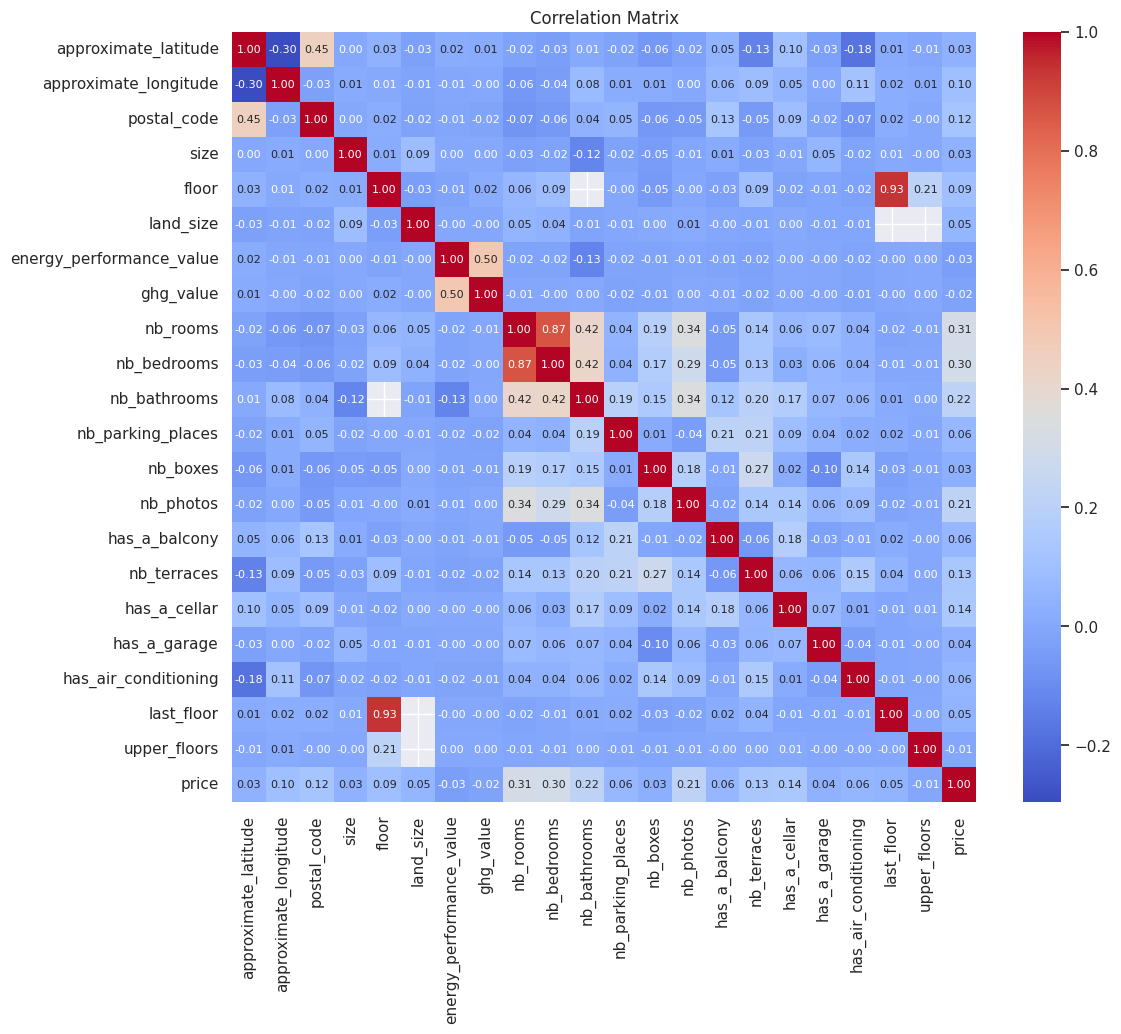

In [501]:
# Calculate the correlation matrix, considering only numeric columns
correlation_matrix = df_raw.select_dtypes(include=np.number).corr()

# You can also visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.show()

Hay una fuerte correlación entre floor y last floor, son redundantes.

| Column                         | Missing Values | Percentage (%) | Strategy |
|--------------------------------|---------------|---------------|----------|
| exposition                     | 28,274        | 75.66%        | Descartar variable|
| floor                          | 27,625        | 73.93%        | Descartar variable|
| land_size                      | 21,787        | 58.30%        |Imputar media para propiedades con terreno|
| ghg_value                      | 18,838        | 50.41%        |Descartar variable, redundante|
| ghg_category                   | 18,838        | 50.41%        |Desconocido para valores faltantes|
| energy_performance_value       | 18,300        | 48.97%        |Descartar variable, redundante|
| energy_performance_category    | 18,300        | 48.97%        |Desconocido para valores faltantes|
| nb_bathrooms                   | 13,273        | 35.52%        |Imputar media|
| nb_bedrooms                    | 2,733         | 7.31%         |Imputar media|
| nb_rooms                       | 1,566         | 4.19%         |Imputar media|
| size                           | 512           | 1.37%         |Imputar media|


## Transformaciones:

In [502]:
df_processed = df_raw.copy()

In [503]:
# Borrar columnas que no utilizaremos

col_borrar=['exposition',  #Descartar Variable, muy pocos valores


            # Redundantes:
            'ghg_value',
            'energy_performance_value',
            'city',
            'floor',
            ]
df_processed = df_processed.drop(columns= col_borrar)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37368 entries, 35996577 to 35748883
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   property_type                37368 non-null  object 
 1   approximate_latitude         37368 non-null  float64
 2   approximate_longitude        37368 non-null  float64
 3   postal_code                  37368 non-null  int64  
 4   size                         36856 non-null  float64
 5   land_size                    15581 non-null  float64
 6   energy_performance_category  19068 non-null  object 
 7   ghg_category                 18530 non-null  object 
 8   nb_rooms                     35802 non-null  float64
 9   nb_bedrooms                  34635 non-null  float64
 10  nb_bathrooms                 24095 non-null  float64
 11  nb_parking_places            37368 non-null  int64  
 12  nb_boxes                     37368 non-null  int64  
 13  nb_photos  

In [504]:
# Lista de tipos de apartamento
apartment_types = ['apartment']

# Imputación para columnas categóricas (rellenamos con 'Desconocido')
cat_cols = ['ghg_category', 'energy_performance_category']
cat_imputer = SimpleImputer(strategy='constant', fill_value='Desconocido')
df_processed[cat_cols] = cat_imputer.fit_transform(df_processed[cat_cols])

# Tratamiento especial para 'land_size':
# Para propiedades tipo apartamento, si 'land_size' es nulo se asigna 0.
mask = (df_processed['property_type'].str.lower().isin(apartment_types)) & (df_processed['land_size'].isnull())
df_processed.loc[mask, 'land_size'] = 0

# Imputación para columnas numéricas con estrategia de la media
num_cols = ['nb_bathrooms', 'nb_bedrooms', 'nb_rooms', 'size', 'land_size']
num_imputer = SimpleImputer(strategy='mean')
df_processed[num_cols] = num_imputer.fit_transform(df_processed[num_cols])

In [505]:
# Create a DataFrame with only the rows where land_size is null
null_land_size_df = df_raw[df_raw['land_size'].isnull()]

# Group by property_type and count the occurrences
property_type_counts = null_land_size_df.groupby('property_type')['property_type'].count()

# Display the result
property_type_counts.sort_values(ascending=False)


,property_type
property_type,
appartement,15087
maison,2998
divers,1886
terrain,1100
duplex,213
villa,91
parking,90
terrain à bâtir,88
propriété,78


In [506]:
describe_datos(df_processed)

,dtypes,null,nunique,unique
property_type,object,0,22,"[appartement, maison, propriété, divers, duple..."
approximate_latitude,float64,0,37368,"[43.64387987003234, 45.695756723197945, 47.966..."
approximate_longitude,float64,0,37368,"[7.117182951005137, 4.89560993095212, -1.22045..."
postal_code,int64,0,4726,"[6270, 69200, 35130, 44360, 69007, 91380, 9220..."
size,float64,0,4479,"[63.0, 90.0, 61.0, 142.0, 88.0, 92.0, 1758.0, ..."
land_size,float64,0,3722,"[3995.6653616584304, 370.0, 764.0, 25700.0, 39..."
energy_performance_category,object,0,8,"[Desconocido, D, B, C, A, E, F, G]"
ghg_category,object,0,8,"[Desconocido, E, B, C, D, A, F, G]"
nb_rooms,float64,0,45,"[3.0, 5.0, 2.0, 4.0, 6.0, 9.0, 12.0, 0.0, 16.0..."
nb_bedrooms,float64,0,45,"[2.0, 4.0, 1.0, 3.0, 5.0, 6.0, 0.0, 8.0, 7.0, ..."


Sin valores nulos

In [507]:
df_processed.describe().T

,count,mean,std,min,25%,50%,75%,max
approximate_latitude,37368.0,46.546155,2.356581,41.374436,43.921547,46.939440,48.841511,5.107589e+01
approximate_longitude,37368.0,2.619087,2.597060,-4.733545,1.096014,2.380793,4.624248,9.503198e+00
postal_code,37368.0,53598.371655,28807.220527,1000.000000,30150.000000,59000.000000,78210.000000,9.588000e+04
size,37368.0,1088.831615,5517.130287,1.000000,74.000000,117.000000,250.000000,4.113110e+05
land_size,37368.0,3995.665362,35137.095523,1.000000,1041.750000,3995.665362,3995.665362,6.203700e+06
nb_rooms,37368.0,4.245405,2.924505,0.000000,3.000000,4.000000,5.000000,1.300000e+02
nb_bedrooms,37368.0,2.864877,2.076156,0.000000,2.000000,3.000000,4.000000,1.180000e+02
nb_bathrooms,37368.0,0.920730,0.217432,0.000000,0.920730,1.000000,1.000000,3.000000e+00
nb_parking_places,37368.0,0.293486,0.455365,0.000000,0.000000,0.000000,1.000000,1.000000e+00
nb_boxes,37368.0,0.179699,0.383942,0.000000,0.000000,0.000000,0.000000,1.000000e+00


## Análisis de correlación

In [508]:
# Calculate the correlation matrix
correlation_matrix = df_processed.select_dtypes(include=np.number).corr()
correlation= correlation_matrix['price'].abs().sort_values(ascending=False)
correlation

,price
price,1.000000
nb_rooms,0.303538
nb_bedrooms,0.289860
nb_photos,0.211963
nb_bathrooms,0.181575
has_a_cellar,0.141069
nb_terraces,0.129738
postal_code,0.122125
approximate_longitude,0.095404
nb_parking_places,0.064793


# Exploración de la variable respuesta

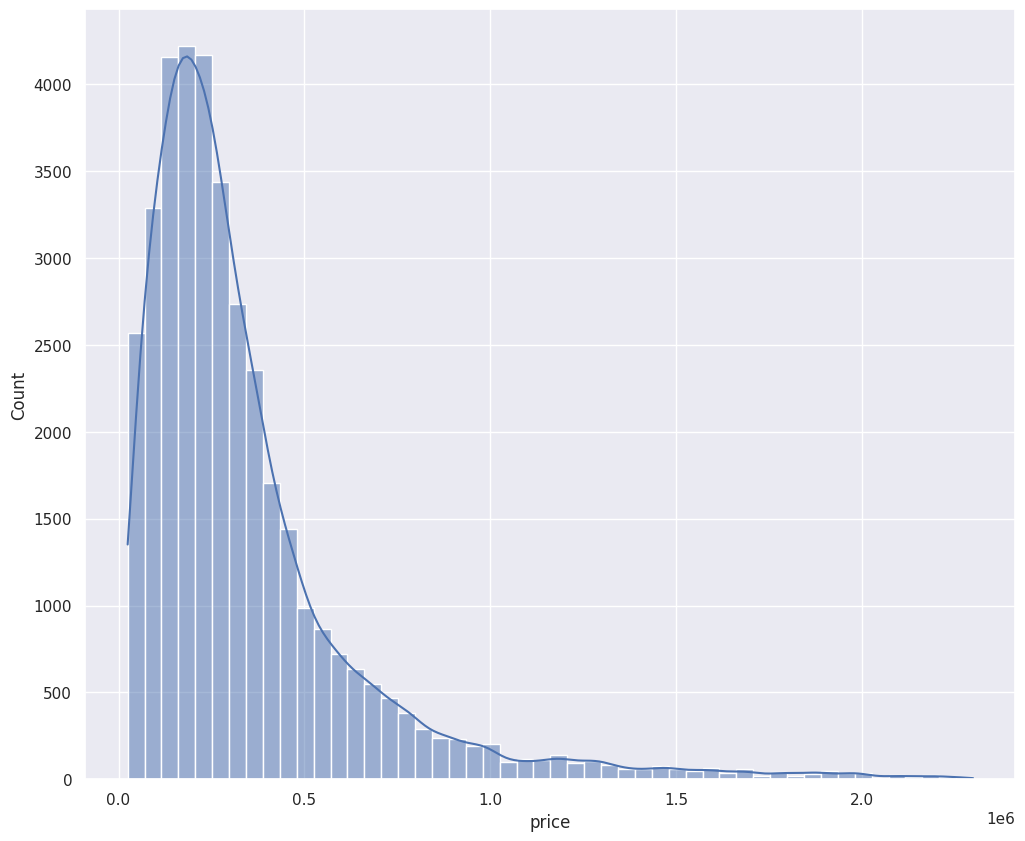

In [509]:
sns.histplot(df_processed['price'], bins=50, kde=True)
plt.show()

In [510]:
df_processed['price'].quantile(.975)

np.float64(1275000.0)

In [511]:
df_processed['aux'] = (df_processed['price'] > df_processed['price'].quantile(.975)).astype(int)

In [512]:
df_processed['aux'].value_counts()

,count
aux,
0,36436
1,932


932 registros están en valores extremos

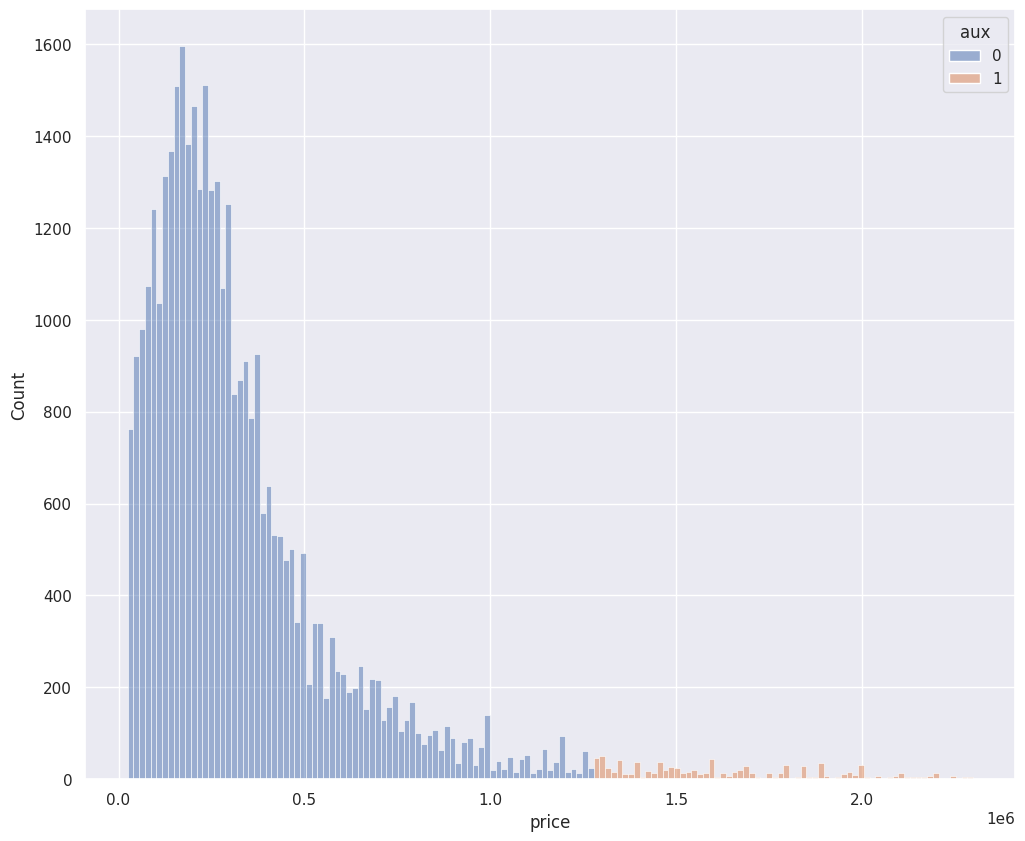

In [513]:
figsize=(12, 4)
muestra = df.sample(10000)
sns.histplot(x='price', hue='aux', data=df_processed )
plt.show()

# One hot encoding variables categoricas

In [514]:
# Create a list of categorical columns to be encoded
categorical_columns = ['property_type', 'energy_performance_category', 'ghg_category']  # Replace with your actual categorical column names

# Apply one-hot encoding using pandas get_dummies
df_encoded = pd.get_dummies(df_processed, columns=categorical_columns, dummy_na=False)

# Convert True/False to 1/0 for all columns
for column in df_encoded.columns:
    # Check if the column has boolean values (True/False)
    if df_encoded[column].dtype == bool:
        df_encoded[column] = df_encoded[column].astype(int)

# Print the encoded dataframe
df_encoded

,approximate_latitude,approximate_longitude,postal_code,size,land_size,nb_rooms,nb_bedrooms,nb_bathrooms,nb_parking_places,nb_boxes,...,energy_performance_category_F,energy_performance_category_G,ghg_category_A,ghg_category_B,ghg_category_C,ghg_category_D,ghg_category_Desconocido,ghg_category_E,ghg_category_F,ghg_category_G
id_annonce,,,,,,,,,,,,,,,,,,,,,
35996577,43.643880,7.117183,6270,63.0,3995.665362,3.0,2.000000,0.92073,0,0,...,0,0,0,0,0,0,1,0,0,0
35811033,45.695757,4.895610,69200,90.0,3995.665362,5.0,4.000000,0.92073,0,0,...,0,0,0,0,0,0,0,1,0,0
35731841,47.966791,-1.220451,35130,61.0,370.000000,2.0,1.000000,0.92073,0,0,...,0,0,0,0,0,0,1,0,0,0
35886765,47.289292,-1.878805,44360,142.0,764.000000,4.0,3.000000,0.92073,0,1,...,0,0,0,0,0,0,0,1,0,0
35781137,45.718992,4.844234,69007,88.0,3995.665362,4.0,3.000000,1.00000,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35881571,43.480292,-1.484324,64100,2995.0,3995.665362,1.0,2.864877,1.00000,0,0,...,0,0,0,0,0,0,0,0,1,0
35890109,48.861391,2.401158,75020,36.0,3995.665362,2.0,1.000000,0.92073,0,0,...,0,0,0,0,0,0,0,1,0,0
36010245,44.397837,-1.164312,40600,99.0,3995.665362,4.0,3.000000,0.92073,1,0,...,0,0,0,0,0,0,1,0,0,0


In [515]:
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Index: 37368 entries, 35996577 to 35748883
Data columns (total 58 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   approximate_latitude                     37368 non-null  float64
 1   approximate_longitude                    37368 non-null  float64
 2   postal_code                              37368 non-null  int64  
 3   size                                     37368 non-null  float64
 4   land_size                                37368 non-null  float64
 5   nb_rooms                                 37368 non-null  float64
 6   nb_bedrooms                              37368 non-null  float64
 7   nb_bathrooms                             37368 non-null  float64
 8   nb_parking_places                        37368 non-null  int64  
 9   nb_boxes                                 37368 non-null  int64  
 10  nb_photos                                

# Creación de modelo:

In [527]:
X = df_encoded.drop([ 'price', 'aux'], axis=1)
y = df_encoded['price']

In [528]:
X_estandarizados = X.copy()
columnas = X.columns

scaler = StandardScaler()

X_estandarizados[columnas] = scaler.fit_transform(X[columnas])

In [529]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)

In [531]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (28026, 56)
y:  (28026,)
Conjunto de prueba
X:  (9342, 56)
y:  (9342,)


## Regresión Lineal

In [533]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred ))

MAE: 178749.56918834522


### Análisis de errores

In [534]:
#calculamos los errores
errores = (y_test - y_pred)
len(errores)

9342

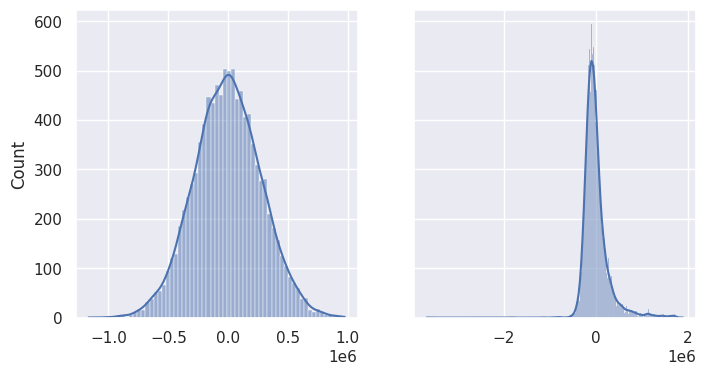

In [535]:
# Comparación de la distribución teórica(normal) y empirica de los errores

media = np.mean(errores)
des_est = np.std(errores)
errores_teoricos = np.random.normal(media, des_est, 10000)
muestra_errores = np.random.choice(errores, 10000)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, muestra_errores), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

In [522]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal

print(f'kurtosis: {kurtosis(errores)}')


kurtosis: 14.585339765174783


Curtosis muy alta, lo que indica que la regresión lineal no es el modelo ideal para este problema.

## Regresi'on de Huber

In [560]:
hr = HuberRegressor()
hr = hr.fit(X_train, y_train)
y_pred_hr = hr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_hr))

MAE: 190794.55242858693


Se buscaran los mejores parámetros para reducir el MAE a un menor valor por medio de GridSearch

In [562]:
param_grid = {
    'epsilon': [1, 1.5, 2],
    'max_iter': [1000, 2000],
    'alpha': [0.001, 1],
    'tol': [0.001]
}

# Create a HuberRegressor instance
hr = HuberRegressor()

# Set up the grid search with 5-fold cross-validation using negative mean absolute error as the scoring metric
grid_search = GridSearchCV(estimator=hr, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Output the best hyperparameters and score found during the search
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Evaluate the tuned model on the test set
y_pred_best = grid_search.predict(X_test)
print("MAE best:", metrics.mean_absolute_error(y_test, y_pred_best))


Best hyperparameters: {'alpha': 0.001, 'epsilon': 2, 'max_iter': 1000, 'tol': 0.001}
Best score: -179446.06688599745
MAE best: 175925.44768185378


In [563]:
#calculamos los errores
errores_hr = (y_test - y_pred_best)
len(errores_hr)

9342

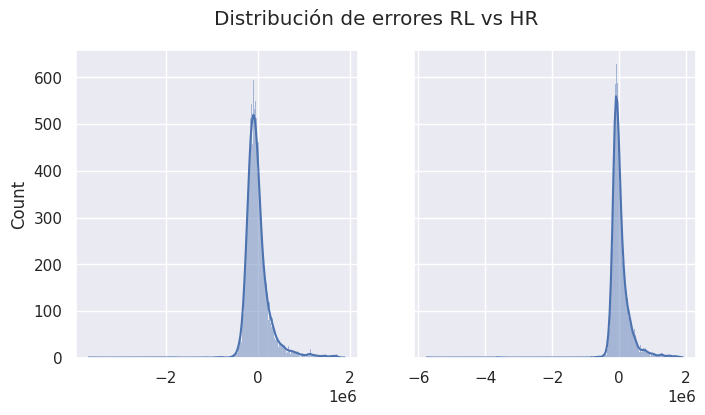

In [564]:
# Comparación de la distribución empirica de los errores de regresión lineal y regresión de hubber

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
plt.suptitle('Distribución de errores RL vs HR')
for dat, subplot in zip((muestra_errores,
                         np.random.choice(errores_hr,10000)), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )


plt.show()

In [565]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal
print(f'kurtosis: {kurtosis(errores_hr)}')

kurtosis: 27.904203693997754


## Coeficientes:

In [566]:
coeficientes_hr_st = pd.Series(grid_search.best_estimator_.coef_, index= columnas)

# Calculate absolute values of coefficients
coeficientes_hr_st_abs = coeficientes_hr_st.abs()

# Create a DataFrame with feature names and absolute coefficients
coef_abs_df = pd.DataFrame({
    'Feature': columnas,  # Assuming 'columnas' holds feature names
    'Absolute_Coefficient': coeficientes_hr_st_abs.values
})

# Sort by absolute coefficient values in descending order
coef_abs_df_sorted = coef_abs_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Display the sorted DataFrame
coef_abs_df_sorted.head(10)

,Feature,Absolute_Coefficient
18,property_type_appartement,24565.768712
5,nb_rooms,23839.152575
6,nb_bedrooms,20160.427065
30,property_type_maison,19456.879859
12,nb_terraces,16474.475938
8,nb_parking_places,12001.919679
41,energy_performance_category_B,7390.674608
45,energy_performance_category_E,6377.403015
11,has_a_balcony,6226.442452
42,energy_performance_category_C,5791.877987


Con base en los coeficientes, el modelo es sensible a las características estructurales y de comodidad de la propiedad (habitaciones, terrazas, estacionamiento)

## Conclusión:

* De acuerdo a la limpieza y exploración, nos damos cuenta que es necesario siempre ser sensible a estas caracteristicas que les hacen falta datos (nans). Hacer una imputación correcta nos ayuda a tener un mejor dataset preparado para crear modelos más acertados.

* Siempre es necesario poder revisar las hipotesis que se cumplan, en este caso al ver una alta curtosis en la distribución del error nos muestra que una regresión lineal no es el mejor modelo para predecir.